## CosyVoice2-EU: Run Evaluation + LaTeX Table Builder

In [1]:
import os
import re
import math
from dataclasses import dataclass
from typing import Optional, Dict, Any, List, Tuple
from pathlib import Path
from tqdm.notebook import tqdm

from itertools import islice

import wandb
import pandas as pd
import numpy as np

import glob, yaml
from datetime import datetime


import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

### Config

In [2]:
ENTITY  = "tlh45"
PROJECT = "CosyVoice2-EU"

# expected hours-per-language
EXPECTED_BASE_HOURS = [50, 100, 250, 500, 1000, 1500]
# models/components we care about
ALLOWED_MODELS = {"llm", "flow"}

# Naming pattern:
# {model}_{hours}h-blanken-lora_false-{FR|DE|""}
# Accept:
#   llm_100h-blanken-lora_false
#   llm_100h-blanken_lora_false
#   llm_100h-blanken-lora_false-FR
#   llm_100h-blanken-lora_false_DE
# (MIX when no FR/DE suffix)
NAME_RE = re.compile(
    r"^(?P<model>llm|flow)_(?P<hours>\d+)h-blanken[-_]lora[-_]false(?:[-_](?P<lang>FR|DE))?$",
    flags=re.IGNORECASE
)


In [3]:
def set_matplotlib_style():
    mpl.rcParams.update({
        # Fonts
        "font.family": "serif",
        "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
        "mathtext.fontset": "stix",
        "axes.unicode_minus": False,

        # Text sizes (pt)
        "axes.titlesize": 10,
        "axes.labelsize": 9,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
        "legend.fontsize": 8,

        # Lines/markers
        "axes.linewidth": 0.8,
        "lines.linewidth": 1.2,

        # Save as vector-friendly
        "pdf.fonttype": 42,  # TrueType in PDF
        "ps.fonttype": 42,

        # Layout / figure
        "figure.dpi": 150,
        "savefig.bbox": "tight",
        "savefig.pad_inches": 0.0,
    })

set_matplotlib_style()


In [4]:

# IEEE-ish sizes
SINGLE_COL_W = 3.39  # inches (IEEE single column)
DOUBLE_COL_W = 7.16  # inches (IEEE double column)



In [5]:
def _finalize_axes(ax, title=None, xlabel=None, ylabel=None, legend=False):
    if title:
        ax.set_title(title, pad=4)
    if xlabel:
        ax.set_xlabel(xlabel, labelpad=2)
    if ylabel:
        ax.set_ylabel(ylabel, labelpad=2)

    # Clean spines
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)

    # Light y-grid
    ax.grid(axis="y", alpha=0.25, linewidth=0.6)
    if legend:
        leg = ax.legend(frameon=False, handlelength=1.5, borderpad=0.2, loc="best")
        for lh in getattr(leg, "legendHandles", []):
            lh.set_linewidth(1.0)

def _save_and_show(fig, outpath_pdf: str, show=True):
    Path(outpath_pdf).parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(outpath_pdf, format="pdf", bbox_inches="tight", pad_inches=0)
    if show:
        display(fig)
    plt.close(fig)

# --- Your existing helpers kept as-is (hours, latex) ---
def _safe_hours(x):
    try:
        return float(x) / 3600.0
    except Exception:
        return 0.0

def _fmt_hours(h):
    return f"{h:,.2f}"

def _fmt_pct(p):
    return f"{p*100:.1f}\\%"

def _clean_df(df, valid_only=True):
    if 'language' in df.columns:
        df['language'] = df['language'].fillna('Unknown')
    else:
        df['language'] = 'Unknown'
    if 'dataset_type' in df.columns:
        df['dataset_type'] = df['dataset_type'].fillna('Unknown')
    else:
        df['dataset_type'] = 'Unknown'

    df['duration'] = pd.to_numeric(df['duration'], errors='coerce').fillna(0.0)
    df = df[df['duration'] > 0]

    if valid_only and 'is_valid' in df.columns:
        df = df[df['is_valid'] == True]

    df['language'] = df['language'].apply(lambda x: x if x in ['FR', 'DE'] else 'Other')
    return df

def _hours_by(group_df, by_cols):
    agg = (group_df
           .groupby(by_cols, dropna=False)['duration']
           .sum()
           .reset_index())
    agg['hours'] = agg['duration'].apply(_safe_hours)
    return agg

def _latex_overview_table(df, outpath_tex, caption="Corpus overview by language", label="tab:dataset_overview"):
    rows = []
    for name, filt in [("Total", df.index), ("French (FR)", df['language']=="FR"), ("German (DE)", df['language']=="DE")]:
        sub = df.loc[filt]
        hours = _safe_hours(sub['duration'].sum())
        files = len(sub)
        avg_sec = sub['duration'].mean() if files > 0 else 0
        med_sec = sub['duration'].median() if files > 0 else 0
        avg_word_count = sub['word_count'].mean() if files > 0 else 0
        libri_sec = sub.loc[sub['dataset_type']=="LibriSpeech", 'duration'].sum()
        emonet_sec = sub.loc[sub['dataset_type']=="EmoNet", 'duration'].sum()
        total_sec = sub['duration'].sum()
        libri_ratio = (libri_sec / total_sec) if total_sec > 0 else 0
        emonet_ratio = (emonet_sec / total_sec) if total_sec > 0 else 0
        rows.append({
            "name": name,
            "hours": hours,
            "files": files,
            "avg": avg_sec,
            "avg_word": avg_word_count,
            "libri_pct": libri_ratio,
            "emonet_pct": emonet_ratio
        })

        # file_path,duration,split,language,dataset_type,voice,char_count,word_count,file_size_wav,is_valid

    lines = []
    lines.append("\\begin{table}[htbp]")
    lines.append("\\centering")
    lines.append(f"\\caption{{{caption}}}")
    lines.append(f"\\label{{{label}}}")
    lines.append("\\begin{tabular}{lrrrrr}")
    lines.append("\\toprule")
    lines.append(" & Hours & Files & Avg dur (s) & Avg word count & Libri/Emo \\\\")
    lines.append("\\midrule")
    for r in rows:
        lines.append(
            f"{r['name']} & "
            f"{_fmt_hours(r['hours'])} & "
            f"{r['files']:,} & "
            f"{r['avg']:.2f} & "
            f"{r['avg_word']:.2f} & "
            f"{_fmt_pct(r['libri_pct'])}/{_fmt_pct(r['emonet_pct'])} \\\\"
        )
    lines.append("\\bottomrule")
    lines.append("\\end{tabular}")
    lines.append("\\end{table}")

    Path(outpath_tex).parent.mkdir(parents=True, exist_ok=True)
    with open(outpath_tex, "w", encoding="utf-8") as f:
        f.write("\n".join(lines))
    print(f"[LaTeX] wrote {outpath_tex}")

# --- Polished figures (PDF + inline display) ---
def plot_hours_by_language(df, outpdf, show=True, width=SINGLE_COL_W, height=2.2):
    hours = _hours_by(df, ['language'])
    order = ['FR', 'DE']
    hours = hours[hours['language'].isin(order)]
    hours = hours.set_index('language').reindex(order).reset_index()

    fig, ax = plt.subplots(figsize=(width, height))
    bars = ax.bar(hours['language'], hours['hours'])

    # Labels on bars
    for rect, h in zip(bars, hours['hours']):
        ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(),
                f"{h:.0f}h", ha='center', va='bottom', fontsize=8)

    _finalize_axes(ax,
        # title="Total Hours by Language",
        xlabel="Language",
        ylabel="Hours",
        legend=False
    )
    _save_and_show(fig, outpdf, show=show)

def plot_stacked_hours_by_language_dataset(df, outpdf, show=True, width=3.9, height=2.3):
    # Slightly wider than single column to fit legend comfortably
    g = _hours_by(df, ['language','dataset_type'])
    langs = ['FR','DE']
    datasets = ['LibriSpeech','EmoNet']

    pv = g.pivot_table(index='language', columns='dataset_type', values='hours', fill_value=0.0)
    pv = pv.reindex(index=[x for x in langs if x in pv.index], columns=[x for x in datasets if x in pv.columns])

    fig, ax = plt.subplots(figsize=(width, height))
    bottom = np.zeros(len(pv.index))
    for col in pv.columns:
        vals = pv[col].values
        ax.bar(pv.index, vals, bottom=bottom, label=col)
        bottom += vals

    _finalize_axes(ax,
        # title="Hours by Language and Dataset",
        xlabel="Language",
        ylabel="Hours",
        legend=True
    )
    _save_and_show(fig, outpdf, show=show)


def plot_stacked_hours_abs_with_pct(
    df, outpdf, show=True, width=3.9, height=2.3, bar_width=0.5
):
    """
    Stacked bars of absolute hours (LibriSpeech+EmoNet) per language.
    Annotates each segment with its share (%) of the language total.
    Colors match histogram defaults; slimmer bars; legend above.
    """
    import matplotlib.patheffects as pe

    langs = ['FR', 'DE']
    datasets = ['LibriSpeech', 'EmoNet']
    colors = {'LibriSpeech': 'C0', 'EmoNet': 'C1'}

    # hours aggregation
    g = (df.groupby(['language','dataset_type'])['duration'].sum().reset_index())
    g = g[g['language'].isin(langs)]
    pv = g.pivot_table(index='language', columns='dataset_type', values='duration', fill_value=0.0)
    pv = pv.reindex(index=[x for x in langs if x in pv.index], columns=[d for d in datasets if d in pv.columns])

    hours = (pv / 3600.0)  # convert to hours for bar heights
    totals_h = hours.sum(axis=1)

    fig, ax = plt.subplots(figsize=(width, height))
    x = np.arange(len(hours.index))
    bottom = np.zeros(len(hours.index))

    handles = []
    labels = []
    for col in hours.columns:
        vals = hours[col].values
        h = ax.bar(x, vals, bottom=bottom, width=bar_width, label=col, color=colors.get(col, None), alpha=0.6)
        handles.append(h)
        labels.append(col)

        # annotate percentages inside each segment
        for i, v in enumerate(vals):
            if v <= 0: 
                continue
            share = (v / totals_h.iloc[i]) if totals_h.iloc[i] > 0 else 0.0
            if share > 0.06:  # annotate only if big enough to read
                y_center = bottom[i] + v/2
                ax.text(
                    x[i], y_center, f"{share*100:.0f}%",
                    ha='center', va='center', fontsize=8,
                    color='black',
                    # path_effects=[pe.withStroke(linewidth=1.2, foreground='black')]
                )
        bottom += vals

    ax.set_xticks(x)
    ax.set_xticklabels(hours.index)

    # Numeric hour labels above bars (compact)
    for i, total in enumerate(totals_h.values):
        ax.text(x[i], total, f"{total:.0f}h", ha='center', va='bottom', fontsize=8)

    # Legend above, outside (prevents overlap)
    ax.legend(
        handles=[h[0] for h in handles],
        labels=labels,
        frameon=False,
        loc="upper left",
        ncol=1
    )
    _finalize_axes(ax, xlabel="Language", ylabel="Hours", legend=False)
    _save_and_show(fig, outpdf, show=show)



def plot_composition_100_stacked_by_language_dataset(
    df, outpdf, show=True, width=3.39, height=2.0, bar_width=0.5
):
    """
    100% stacked bars (LibriSpeech vs EmoNet) per language (FR/DE).
    More compact than raw-hour bars; emphasizes composition, not absolute size.
    """
    langs = ['FR', 'DE']
    datasets = ['LibriSpeech', 'EmoNet']

    g = (df.groupby(['language','dataset_type'])['duration'].sum().reset_index())
    g = g[g['language'].isin(langs)]
    # pivot to seconds
    pv = g.pivot_table(index='language', columns='dataset_type', values='duration', fill_value=0.0)
    # keep only known datasets; handle missing columns
    pv = pv.reindex(index=[x for x in langs if x in pv.index], columns=[d for d in datasets if d in pv.columns])

    # normalize to 100%
    totals = pv.sum(axis=1).replace(0, 1.0)
    comp = (pv.T / totals).T  # fractions

    fig, ax = plt.subplots(figsize=(width, height))

    x = np.arange(len(comp.index))
    bottom = np.zeros(len(comp.index))
    for col in comp.columns:
        vals = comp[col].values
        ax.bar(x, vals, bottom=bottom, width=bar_width, label=col)
        bottom += vals

    ax.set_xticks(x)
    ax.set_xticklabels(comp.index)
    ax.set_ylim(0, 1.0)

    # add percent labels
    for i, lang in enumerate(comp.index):
        start = 0.0
        for col in comp.columns:
            v = comp.loc[lang, col]
            if v > 0.05:  # only annotate sizable slices
                ax.text(i, start + v/2, f"{v*100:.0f}%", ha='center', va='center', fontsize=8)
            start += v

    _finalize_axes(ax,
        xlabel="Language",
        ylabel="Share",
        legend=True
    )
    _save_and_show(fig, outpdf, show=show)


def plot_duration_hist_overall(df, outpdf, show=True, max_sec=60, bins=48, width=SINGLE_COL_W, height=2.2):
    dd = df['duration'].clip(upper=max_sec)
    fig, ax = plt.subplots(figsize=(width, height))
    ax.hist(dd, bins=bins)

    _finalize_axes(ax,
        # title=f"Clip Duration Distribution (0–{max_sec}s)",
        xlabel="Clip length (s)",
        ylabel="Count",
        legend=False
    )
    _save_and_show(fig, outpdf, show=show)

def plot_duration_hist_by_dataset(df, outpdf, show=True, max_sec=60, bins=48, width=3.9, height=2.3):
    fig, ax = plt.subplots(figsize=(width, height))
    # Ensure order: LibriSpeech (blue), EmoNet (orange)
    dataset_order = ['LibriSpeech', 'EmoNet']
    colors = {'LibriSpeech': 'C0', 'EmoNet': 'C1'}
    for ds_name in dataset_order:
        if ds_name in df['dataset_type'].unique():
            sub = df[df['dataset_type'] == ds_name]
            dd = sub['duration'].clip(upper=max_sec)
            ax.hist(dd, bins=bins, alpha=0.6, label=ds_name, color=colors[ds_name])

    _finalize_axes(ax,
        # title=f"Clip Duration by Dataset (0–{max_sec}s)",
        xlabel="Clip length (s)",
        ylabel="Count",
        legend=True
    )
    _save_and_show(fig, outpdf, show=show)

def plot_top_speakers(df, outpdf, top_n=15, show=True, width=4.2, height=None):
    if 'voice' not in df.columns:
        return
    agg = _hours_by(df, ['voice']).sort_values('hours', ascending=False).head(top_n)
    if height is None:
        height = max(2.2, 0.28*len(agg))  # compact

    fig, ax = plt.subplots(figsize=(width, height))
    ax.barh(agg['voice'], agg['hours'])
    ax.invert_yaxis()
    for i, h in enumerate(agg['hours']):
        ax.text(h, i, f" {h:.1f}h", va='center', ha='left', fontsize=8)

    _finalize_axes(ax,
        title=f"Top {len(agg)} Speakers by Duration",
        xlabel="Hours",
        ylabel=None,
        legend=False
    )
    _save_and_show(fig, outpdf, show=show)

## Helpers

In [6]:
def parse_name(name: str) -> Optional[Dict[str, Any]]:
    """
    Parse run name into {model, hours_in_name, lang_label, hours_per_lang}.
    MIX = lang missing => hours_per_lang = hours_in_name // 2
    """
    m = NAME_RE.match(name.strip())
    if not m:
        return None
    model = m.group("model").lower()
    hours_in_name = int(m.group("hours"))
    lang = m.group("lang")
    if lang is None:
        lang_label = "MIX"
        hours_per_lang = hours_in_name // 2
    else:
        lang_label = lang.upper()
        hours_per_lang = hours_in_name
    return {
        "model": model,
        "hours_in_name": hours_in_name,
        "lang_label": lang_label,
        "hours_per_lang": hours_per_lang,
    }


# small pool of metric keys
TRAIN_LOSS_KEYS = [
    "train/loss", "train_loss", "training/loss", "loss/train", "loss",
    "train_loss_epoch", "step_train_loss"
]


VAL_LOSS_KEYS = [
    "val/loss", "valid/loss", "validation/loss", "val_loss", "eval/loss",
    "best/val_loss", "best_val_loss", "cv_loss", "cv/loss"
]


TRAIN_ACC_KEYS = [
    "train/acc", "train_accuracy", "training/accuracy", "accuracy/train", "accuracy",
    "train_accuracy_epoch", "step_train_accuracy"
]


VAL_ACC_KEYS = [
    "val/acc", "valid/acc", "validation/accuracy", "val_accuracy", "eval/acc",
    "best/val_accuracy", "best_val_accuracy", "cv_accuracy", "cv/acc"
]


STEP_KEYS = ["global_step", "step", "_step", "trainer/global_step", "epoch"]

def first_present(d: Dict[str, Any], keys: List[str]) -> Optional[str]:
    for k in keys:
        if k in d and d[k] is not None:
            return k
    return None

def extract_summary_metrics(run: wandb.apis.public.Run) -> Tuple[Optional[float], Optional[float], Optional[float], Optional[int]]:
    """
    Try to get final train loss, final/summary val loss, and best val loss,
    plus a step indicator from Run.summary.
    If unavailable, leave as None (you can later compute from history if needed).
    """
    summ = dict(run.summary or {})
    # Train loss
    tr_k = first_present(summ, TRAIN_LOSS_KEYS)
    train_loss = float(summ[tr_k]) if tr_k else None
    
    # Val loss (summary/best)
    val_k = first_present(summ, VAL_LOSS_KEYS)
    val_loss = float(summ[val_k]) if val_k and "best" not in val_k.lower() else None
    best_val_loss = float(summ[val_k]) if val_k and "best" in val_k.lower() else None

    # Accuracy
    tr_acc_k = first_present(summ, TRAIN_ACC_KEYS)
    train_acc = float(summ[tr_acc_k]) if tr_acc_k else None

    val_acc_k = first_present(summ, VAL_ACC_KEYS)
    val_acc = float(summ[val_acc_k]) if val_acc_k else None

    
    # Step-ish
    st_k = first_present(summ, STEP_KEYS)
    step_val = int(summ[st_k]) if (st_k and isinstance(summ[st_k], (int, float))) else None
    return train_loss, val_loss, best_val_loss, train_acc, val_acc, step_val


In [7]:
api = wandb.Api()
runs = api.runs(f"{ENTITY}/{PROJECT}")

print("Sample run names (first 25):")
for r in islice(runs, 25):
    print("-", r.name)

Sample run names (first 25):
- llm_100h-hf-utter-project-EuroLLM-1.7B-Instruct
- flow_100h-hf-utter-project-EuroLLM-1.7B-Instruct
- llm_100h-hf-Qwen-Qwen3-0.6B
- flow_100h-hf-Qwen-Qwen3-0.6B
- llm_1000h-blanken
- flow_1000h-blanken
- llm_200h-hf-Qwen-Qwen3-0.6B
- flow_500h-blanken
- llm_2000h-blanken
- llm_500h-hf-Qwen-Qwen3-0.6B
- llm_500h-blanken
- llm_3000h-hf-Qwen-Qwen3-0.6B
- llm_3000h-blanken-OLD
- llm_3000h-hf-utter-project-EuroLLM-1.7B-Instruct
- llm_2000h-hf-utter-project-EuroLLM-1.7B-Instruct
- llm_3000h-hf-utter-project-EuroLLM-1.7B-Instruct-lora_true
- llm_3000h-hf-Qwen-Qwen3-0.6B-lora_true
- flow_100h-blanken-lora_false
- llm_2000h-hf-utter-project-EuroLLM-1.7B-Instruct-lora_true
- llm_1000h-hf-utter-project-EuroLLM-1.7B-Instruct-lora_true
- llm_200h-blanken-lora_false
- llm_500h-blanken-lora_false
- llm_3000h-hf-utter-project-EuroLLM-1.7B-Instruct-lora_true
- flow_500h-blanken-lora_false
- flow_200h-blanken-lora_false


### Fetch & Filter W&B runs (strict naming), detect duplicates/missing

In [8]:
api = wandb.Api()
runs = api.runs(f"{ENTITY}/{PROJECT}")

records = []
for r in runs:
    info = parse_name(r.name or "")
    if not info:
        continue
    if info["model"] not in ALLOWED_MODELS:
        continue

    train_loss, val_loss, best_val_loss, train_acc, val_acc, step_val = extract_summary_metrics(r)

    rec = {
        "run_name": r.name,
        "run_id": r.id,
        "state": r.state,
        "created": pd.to_datetime(r.created_at) if r.created_at else pd.NaT,
        "model": info["model"].upper(),       # LLM / FLOW (uppercased for display)
        "lang": info["lang_label"],           # FR / DE / MIX
        "hours_in_name": info["hours_in_name"],
        "hours_per_lang": info["hours_per_lang"],  # For MIX this is half of hours_in_name
        "train_loss_final": train_loss,
        "val_loss_final": val_loss,
        "val_loss_best": best_val_loss,
        "train_acc_final": train_acc,
        "val_acc_final": val_acc,
        "summary_step": step_val,
        "url": r.url,
    }
    records.append(rec)

df = pd.DataFrame(records).sort_values(
    by=["lang", "model", "hours_per_lang", "created"],
    ascending=[True, True, True, True]
)
len(df), df.head(3)


(36,
                            run_name    run_id     state  \
 11   flow_50h-blanken-lora_false-DE  m091y92d  finished   
 15  flow_100h-blanken-lora_false_DE  naskbzkw  finished   
 19  flow_250h-blanken-lora_false_DE  e9b45152  finished   
 
                      created model lang  hours_in_name  hours_per_lang  \
 11 2025-08-19 02:05:57+00:00  FLOW   DE             50              50   
 15 2025-08-20 09:35:08+00:00  FLOW   DE            100             100   
 19 2025-08-20 09:37:59+00:00  FLOW   DE            250             250   
 
     train_loss_final  val_loss_final val_loss_best  train_acc_final  \
 11          0.109336        0.765219          None              NaN   
 15          0.119527        0.574536          None              NaN   
 19          0.106786        0.529956          None              NaN   
 
     val_acc_final  summary_step  \
 11            NaN         14351   
 15            NaN         28332   
 19            NaN         71692   
 
               

### Sanity checks (counts, duplicates, missing)

In [9]:
def expected_grid():
    # We check LLM/FLOW x (FR, DE, MIX) x EXPECTED_BASE_HOURS
    grid = []
    for lang in ["FR", "DE", "MIX"]:
        for model in ["LLM", "FLOW"]:
            for h in EXPECTED_BASE_HOURS:
                grid.append((lang, model, h))
    return set(grid)

present = set(zip(df["lang"], df["model"], df["hours_per_lang"]))
missing = sorted(list(expected_grid() - present))
present_count = df.groupby(["lang","model","hours_per_lang"], as_index=False).size()

# Duplicates = same (lang, model, hours_per_lang) > 1
dups = present_count[present_count["size"] > 1].sort_values(["lang","model","hours_per_lang"])

print("Total filtered runs:", len(df))
print("Unique (lang, model, hours):", len(present))
print("\nExpected combos:", len(expected_grid()), " → 36 (12 per language group)")
print("Missing combos (if any):")
for lang, model, h in missing:
    print(f"  - {lang:<3} | {model:<4} | {h:>4}h")

print("\nDuplicates (same lang+model+hours_per_lang):")
display(dups)

# Show duplicates in more detail (the runs themselves)
if not dups.empty:
    key_cols = ["lang","model","hours_per_lang"]
    dup_keys = set(map(tuple, dups[key_cols].values))
    df_dups = df[df.apply(lambda r: (r["lang"], r["model"], r["hours_per_lang"]) in dup_keys, axis=1)]
    display(df_dups.sort_values(key_cols + ["created"]))


Total filtered runs: 36
Unique (lang, model, hours): 36

Expected combos: 36  → 36 (12 per language group)
Missing combos (if any):

Duplicates (same lang+model+hours_per_lang):


,lang,model,hours_per_lang,size


In [10]:
# --- Fill best val loss from W&B run history (min over any val/cv loss series)

VAL_HISTORY_PATTERNS = [
    "best/val_loss", "best_val_loss", "val/loss", "valid/loss",
    "validation/loss", "val_loss", "eval/loss", "cv/loss", "cv_loss"
]

def best_val_from_history(run: wandb.apis.public.Run) -> Optional[float]:
    try:
        # Pull enough rows to cover training; W&B paginates internally
        hist = run.history(samples=200000)
        if hist is None or hist.empty:
            return None
        cols = [c for c in hist.columns if any(p in c.lower() for p in VAL_HISTORY_PATTERNS)]
        if not cols:
            return None
        mins = []
        for c in cols:
            s = pd.to_numeric(hist[c], errors="coerce").dropna()
            if len(s):
                mins.append(s.min())
        return float(min(mins)) if mins else None
    except Exception as e:
        # If a run is deleted/archived or API hiccup — just skip
        # print("history error", run.id, e)
        return None

# Build a map {run_id: best_val_hist} for your filtered runs only
best_hist_map = {}
for rid in tqdm(df["run_id"].unique()):
    if rid == "OFFLINE-YAML":  # skip the offline reconstructed row
        best_hist_map[rid] = None
        continue
    try:
        r = api.run(f"{ENTITY}/{PROJECT}/{rid}")
    except Exception:
        best_hist_map[rid] = None
        continue
    best_hist_map[rid] = best_val_from_history(r)

# New filled column: prefer summary 'val_loss_best' if present, else min from history
df["val_loss_best_hist"] = df["run_id"].map(best_hist_map)
df["val_loss_best_filled"] = df["val_loss_best"].where(df["val_loss_best"].notna(), df["val_loss_best_hist"])

  0%|          | 0/36 [00:00<?, ?it/s]

In [11]:
# ============================
# 1) Pull train@BVL from W&B
# ============================
VAL_HISTORY_PATTERNS = [
    "val/loss","valid/loss","validation/loss","val_loss","eval/loss",
    "cv/loss","cv_loss","best/val_loss","best_val_loss"
]
TRAIN_LOSS_HISTORY_KEYS = [
    "train/loss","training/loss","train_loss","loss/train","loss",
    "train_loss_epoch","step_train_loss"
]
TRAIN_ACC_HISTORY_KEYS = [
    "train/acc","training/accuracy","train_accuracy","accuracy/train","accuracy",
    "train_accuracy_epoch","step_train_accuracy"
]
STEP_KEYS = ["global_step","trainer/global_step","step","_step","epoch"]

def _choose_val_col(cols):
    """Prefer non-'best' val-loss columns."""
    cands = [c for c in cols if any(p in c.lower() for p in VAL_HISTORY_PATTERNS)]
    # Rank: non-best first, shorter names earlier
    return sorted(cands, key=lambda c: (("best" in c.lower()), len(c)))  # best=False first

def _first_hist_col_with_value(row, all_cols, key_list):
    for k in key_list:
        c = next((col for col in all_cols if col.lower()==k.lower()), None)
        if c is not None and pd.notna(row.get(c, pd.NA)):
            return c
    # allow partial matches if exact not found
    for k in key_list:
        c = next((col for col in all_cols if k.lower() in col.lower()), None)
        if c is not None and pd.notna(row.get(c, pd.NA)):
            return c
    return None

def _get_step_col(hist):
    for k in STEP_KEYS:
        if k in hist.columns:
            return k
        # allow loose match
        for c in hist.columns:
            if k.lower() in c.lower():
                return c
    return None

def train_at_bvl_from_history(run):
    """Return (train_loss_at_bvl, train_acc_at_bvl) using the row where val-loss is minimal."""
    try:
        hist = run.history(samples=200000)
        if hist is None or hist.empty:
            return None, None
        # pick a validation-loss column and its argmin row
        val_cols = _choose_val_col(hist.columns)
        if not val_cols:
            return None, None
        tl_at_bvl, ta_at_bvl = None, None
        for vc in val_cols:
            s = pd.to_numeric(hist[vc], errors="coerce")
            if s.notna().any():
                idx = s.idxmin()
                if pd.isna(idx):
                    continue
                row = hist.loc[idx]
                # direct same-row read
                tl_col = _first_hist_col_with_value(row, hist.columns, TRAIN_LOSS_HISTORY_KEYS)
                ta_col = _first_hist_col_with_value(row, hist.columns, TRAIN_ACC_HISTORY_KEYS)
                tl_at_bvl = float(row[tl_col]) if tl_col else None
                ta_at_bvl = float(row[ta_col]) if ta_col else None
                # if missing, try step alignment within same step
                if (tl_at_bvl is None or ta_at_bvl is None):
                    step_col = _get_step_col(hist)
                    if step_col in hist.columns and pd.notna(row.get(step_col, pd.NA)):
                        step_val = row[step_col]
                        same_step = hist[pd.to_numeric(hist[step_col], errors="coerce")==step_val]
                        if tl_at_bvl is None:
                            tl_col2 = _first_hist_col_with_value(same_step.iloc[-1], same_step.columns, TRAIN_LOSS_HISTORY_KEYS) if not same_step.empty else None
                            tl_at_bvl = float(same_step.iloc[-1][tl_col2]) if (tl_col2 and not same_step.empty and pd.notna(same_step.iloc[-1][tl_col2])) else None
                        if ta_at_bvl is None:
                            ta_col2 = _first_hist_col_with_value(same_step.iloc[-1], same_step.columns, TRAIN_ACC_HISTORY_KEYS) if not same_step.empty else None
                            ta_at_bvl = float(same_step.iloc[-1][ta_col2]) if (ta_col2 and not same_step.empty and pd.notna(same_step.iloc[-1][ta_col2])) else None
                break
        return tl_at_bvl, ta_at_bvl
    except Exception:
        return None, None

# Build maps for the filtered runs present in df
train_loss_at_bvl_map, train_acc_at_bvl_map = {}, {}
for rid in tqdm(df["run_id"].unique(), desc="W&B history @BVL"):
    if rid == "OFFLINE-YAML":
        train_loss_at_bvl_map[rid] = None
        train_acc_at_bvl_map[rid] = None
        continue
    try:
        r = api.run(f"{ENTITY}/{PROJECT}/{rid}")
    except Exception:
        train_loss_at_bvl_map[rid] = None
        train_acc_at_bvl_map[rid] = None
        continue
    tl, ta = train_at_bvl_from_history(r)
    train_loss_at_bvl_map[rid] = tl
    train_acc_at_bvl_map[rid] = ta

df["train_loss_at_bvl"] = df["run_id"].map(train_loss_at_bvl_map)
df["train_acc_at_bvl"]  = df["run_id"].map(train_acc_at_bvl_map)

# These flags control whether we add daggers in the header:
has_true_tl_at_bvl = df["train_loss_at_bvl"].notna().any()
has_true_ta_at_bvl = df["train_acc_at_bvl"].notna().any()


W&B history @BVL:   0%|          | 0/36 [00:00<?, ?it/s]

### Latex Table

In [12]:
# =========================================
# CONSISTENT PRECISION ACROSS THE TABLE
# =========================================
DECIMALS = 3  # <- set to 2 if you want 2 decimals everywhere

# Assemble BVL + TrL@BVL + TrA@BVL (fallback to final only where missing)
df_work = df.copy()
df_work["Best Val Loss"]    = df_work["val_loss_best_filled"]
df_work["Train Loss @ BVL"] = df_work["train_loss_at_bvl"].where(
    df_work["train_loss_at_bvl"].notna(), df_work["train_loss_final"]
)
df_work["Train Acc @ BVL"]  = df_work["train_acc_at_bvl"].where(
    df_work["train_acc_at_bvl"].notna(), df_work["train_acc_final"]
)

keep_cols = ["hours_per_lang","lang","model","Best Val Loss","Train Loss @ BVL","Train Acc @ BVL"]
df_long = df_work[keep_cols].copy()

# categories & melt→pivot
lang_cat  = pd.CategoricalDtype(categories=["FR","DE","MIX"], ordered=True)
model_cat = pd.CategoricalDtype(categories=["LLM","FLOW"], ordered=True)
df_long["lang"]  = df_long["lang"].astype(lang_cat)
df_long["model"] = df_long["model"].astype(model_cat)

metric_order = ["Best Val Loss","Train Loss @ BVL","Train Acc @ BVL"]
melted = df_long.melt(
    id_vars=["hours_per_lang","lang","model"],
    value_vars=metric_order,
    var_name="Metric",
    value_name="Value"
)
pivot = (
    melted.pivot_table(
        index="hours_per_lang",
        columns=["lang","model","Metric"],
        values="Value",
        aggfunc="first"
    )
    .sort_index()
)

# uniform rounding + abbrev + order
def _round_val(v):
    if pd.isna(v): return None
    return round(float(v), DECIMALS)

metric_abbrev = {"Best Val Loss":"BVL","Train Loss @ BVL":"TrL@BVL","Train Acc @ BVL":"TrA@BVL"}
order_within = ["BVL","TrL@BVL","TrA@BVL"]

def _prepare_subtable(piv, model_name):
    sub = piv.xs((model_name), axis=1, level=1)

    # numeric rounding (keeps df numeric for min/max detection)
    for (lang, metric_long) in sub.columns:
        sub[(lang, metric_long)] = sub[(lang, metric_long)].map(_round_val)

    # abbreviate headers
    sub.columns = pd.MultiIndex.from_tuples(
        [(lang, metric_abbrev.get(m, m)) for (lang, m) in sub.columns],
        names=["",""]
    )

    # drop all-NaN columns (e.g., TrA@BVL for FLOW)
    keep = [c for c in sub.columns if not pd.Series(sub[c]).isna().all()]
    sub = sub.loc[:, keep]

    # order within language blocks
    ordered = []
    for L in [c for c in ["FR","DE","MIX"] if any(col[0]==c for col in sub.columns)]:
        Lcols = [c for c in sub.columns if c[0]==L]
        Lcols = sorted(Lcols, key=lambda c: order_within.index(c[1]) if c[1] in order_within else 999)
        ordered.extend(Lcols)
    sub = sub.loc[:, ordered]

    # SHOW index name → first column header reads "Hours"
    sub.index.name = "Hours"
    return sub

pivot_llm  = _prepare_subtable(pivot, "LLM")
pivot_flow = _prepare_subtable(pivot, "FLOW")

# add daggers ONLY if we had to fallback for ALL runs
# (computed earlier when you fetched W&B history)
# pivot_llm  = _dagger_headers(pivot_llm,  dagger_loss=not has_true_tl_at_bvl, dagger_acc=not has_true_ta_at_bvl)
# pivot_flow = _dagger_headers(pivot_flow, dagger_loss=not has_true_tl_at_bvl, dagger_acc=False)

# format to fixed DECIMALS and highlight (min BVL, max TrA@BVL) per language
def _format_and_highlight(df_sub):
    def fmt(val):
        if pd.isna(val): return ""
        return f"{float(val):.{DECIMALS}f}"

    df_fmt = pd.DataFrame({col: [fmt(v) for v in df_sub[col]] for col in df_sub.columns}, index=df_sub.index)

    langs = [L for L in ["FR","DE","MIX"] if any(c[0]==L for c in df_sub.columns)]
    for L in langs:
        # BVL → bold min
        bvl_cols = [c for c in df_sub.columns if c[0]==L and c[1]=="BVL"]
        for c in bvl_cols:
            s = pd.to_numeric(df_sub[c], errors="coerce")
            if s.notna().any():
                m = s.min()
                for idx in s.index[s==m]:
                    df_fmt.at[idx,c] = r"\textbf{" + df_fmt.at[idx,c] + "}"
        # TrA@BVL → bold max (if present)
        a_cols = [c for c in df_sub.columns if c[0]==L and c[1].startswith("TrA@BVL")]
        for c in a_cols:
            s = pd.to_numeric(df_sub[c], errors="coerce")
            if s.notna().any():
                M = s.max()
                for idx in s.index[s==M]:
                    df_fmt.at[idx,c] = r"\textbf{" + df_fmt.at[idx,c] + "}"
    return df_fmt

pivot_llm_fmt  = _format_and_highlight(pivot_llm)
pivot_flow_fmt = _format_and_highlight(pivot_flow)

# ============================
# LaTeX (with "Hours" header)
# ============================
def _build_cmidrules(df_sub):
    order, last = [], None
    for L in df_sub.columns.get_level_values(0):
        if L!=last: order.append([L,1]); last=L
        else: order[-1][1]+=1
    parts, col_start = [], 2  # start after the "Hours" column
    for _, w in order:
        col_end = col_start + w - 1
        parts.append(f"\\cmidrule(lr){{{col_start}-{col_end}}}")
        col_start = col_end + 1
    return "".join(parts)

def _tight_column_format(n_data_cols):
    return "r" * (1 + n_data_cols)  # index + data

def _insert_cmidrules(tex_core, cmidrules):
    lines = tex_core.splitlines()
    for i, line in enumerate(lines):
        if "\\multicolumn" in line:
            # DO NOT prefix with " & " (we have "Hours" there)
            lines.insert(i+1, cmidrules)
            break
    return "\n".join(lines)

def _latex_booktabs_wrap(df_sub, caption, label, out_tex_path,
                         notes=None, tabcolsep_pt=2.0, fit_to_linewidth=True):
    colfmt = _tight_column_format(df_sub.shape[1])
    tex_core = df_sub.to_latex(
        na_rep="",
        escape=False,
        multirow=True,
        multicolumn=True,
        multicolumn_format="c",
        bold_rows=False,
        caption=None,
        label=None,
        index=True,
        index_names=True,     # ← show "Hours" in the top-left header
        column_format=colfmt,
        longtable=False,
    )

    # booktabs
    if "\\toprule" not in tex_core:
        tex_core = re.sub(r"(\\begin\{tabular\}\{[^\}]+\}\n)", r"\1\\toprule\n", tex_core, count=1)
    tex_core = tex_core.replace("\n\\hline\n", "\n\\midrule\n")
    if "\\bottomrule" not in tex_core:
        tex_core = re.sub(r"\n\\midrule\n(?=[^\\]*$)", "\n\\bottomrule\n", tex_core, count=1)

    tex_core = _insert_cmidrules(tex_core, _build_cmidrules(df_sub))
    core_block = tex_core if not fit_to_linewidth else "\\resizebox{\\linewidth}{!}{%\n" + tex_core + "\n}"

    notes_block = ""
    if notes:
        notes_block = (
            "\\begin{minipage}{\\linewidth}\n"
            "\\begin{tablenotes}[para,flushleft]\n"
            "\\footnotesize " + notes + "\n"
            "\\end{tablenotes}\n"
            "\\end{minipage}\n"
        )

    wrapped = (
        "\\begin{table}[htbp]\n"
        "\\centering\n"
        "\\small\n"
        f"\\setlength{{\\tabcolsep}}{{{tabcolsep_pt}pt}}\n"
        "\\renewcommand{\\arraystretch}{0.95}\n"
        f"\\caption{{{caption}}}\n"
        f"\\label{{{label}}}\n"
        "\\begin{threeparttable}\n"
        f"{core_block}\n"
        f"{notes_block}"
        "\\end{threeparttable}\n"
        "\\end{table}\n"
    )
    Path(out_tex_path).write_text(wrapped, encoding="utf-8")
    print(f"[LaTeX] wrote {out_tex_path}")

# ---------- Footnote + emit ----------
notes = (
    r"\textit{Abbrev.:} BVL = Best Validation Loss (minimum over training); "
    r"TrL@BVL/TrA@BVL = training loss/accuracy at the BVL step (from W\&B history). "
    r"\textit{Selection:} final models are the average of the 5 checkpoints with the lowest validation loss. "
    r"\textit{Emphasis:} bold = per-language best across hours (min BVL, max TrA@BVL)."
)
if not has_true_tl_at_bvl:
    notes += " TrL@BVL\\textsuperscript{\\dag} uses final training loss (per-step value unavailable)."
if not has_true_ta_at_bvl:
    notes += " TrA@BVL\\textsuperscript{\\dag} uses final training accuracy (per-step value unavailable)."

Path("plots").mkdir(parents=True, exist_ok=True)

_latex_booktabs_wrap(
    _format_and_highlight(pivot_llm),
    caption="LLM: best validation loss (BVL) with training metrics at that checkpoint.",
    label="tab:cosy_llm_bvl_aligned",
    out_tex_path="plots/cosyvoice2eu_pivot_llm_bvl_aligned.tex",
    notes=notes,
    tabcolsep_pt=2.0,
    fit_to_linewidth=True,
)

_latex_booktabs_wrap(
    _format_and_highlight(pivot_flow),
    caption="FLOW: best validation loss (BVL) with training loss at that checkpoint.",
    label="tab:cosy_flow_bvl_aligned",
    out_tex_path="plots/cosyvoice2eu_pivot_flow_bvl_aligned.tex",
    notes=notes,  # fine even if TrA@BVL absent
    tabcolsep_pt=2.0,
    fit_to_linewidth=True,
)


[LaTeX] wrote plots/cosyvoice2eu_pivot_llm_bvl_aligned.tex
[LaTeX] wrote plots/cosyvoice2eu_pivot_flow_bvl_aligned.tex


/tmp/ipykernel_1743787/747309024.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[(lang, metric_long)] = sub[(lang, metric_long)].map(_round_val)
/tmp/ipykernel_1743787/747309024.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[(lang, metric_long)] = sub[(lang, metric_long)].map(_round_val)
/tmp/ipykernel_1743787/747309024.py:148: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The argume

### Plots

Data efficiency curves (RQ2)

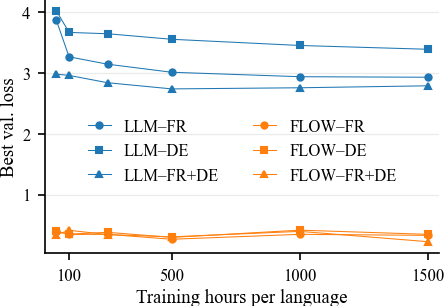

In [13]:
df_eff = df.copy()
df_eff = df_eff[~df_eff["val_loss_best_filled"].isna()].copy()
df_eff = df_eff.sort_values(["model","lang","hours_per_lang"])

markers = {"FR": "o", "DE": "s", "MIX": "^"}
colors  = {"LLM": "C0", "FLOW": "C1"}
lw = 0.5

# show fewer x labels to avoid overlap
all_hours = sorted(df_eff["hours_per_lang"].unique())
label_ticks = [h for h in [100, 500, 1000, 1500] if h in all_hours]

fig, ax = plt.subplots(figsize=(SINGLE_COL_W, 2.2))

for model in ["LLM", "FLOW"]:
    for lang in ["FR", "DE", "MIX"]:
        sub = df_eff[(df_eff["model"] == model) & (df_eff["lang"] == lang)]
        if sub.empty:
            continue
        x = sub["hours_per_lang"].values
        y = sub["val_loss_best_filled"].values
        order = np.argsort(x)
        ax.plot(
            x[order], y[order],
            marker=markers[lang], linestyle="-",
            linewidth=lw, markersize=3,
            color=colors[model],
            label=f"{model}–{'FR+DE' if lang == 'MIX' else lang}",
        )

# ticks (no overlap), light margins
ax.set_xticks(label_ticks)
ax.set_xticklabels([str(int(t)) for t in label_ticks])
ax.margins(x=0.03)

_finalize_axes(
    ax,
    title=None,
    xlabel="Training hours per language",
    ylabel="Best val. loss",
    legend=False,
)

# legend: in the center of the plot, split into two columns of 3 rows, slightly moved down
leg = ax.legend(
    loc="center",
    frameon=False,
    handlelength=1.4,
    borderpad=0.2,
    ncol=2,
    bbox_to_anchor=(0.5, 0.4)
)

Path("plots").mkdir(parents=True, exist_ok=True)
_save_and_show(fig, "plots/efficiency_val_loss.pdf", show=True)


MIX vs Mono advantage (RQ3)

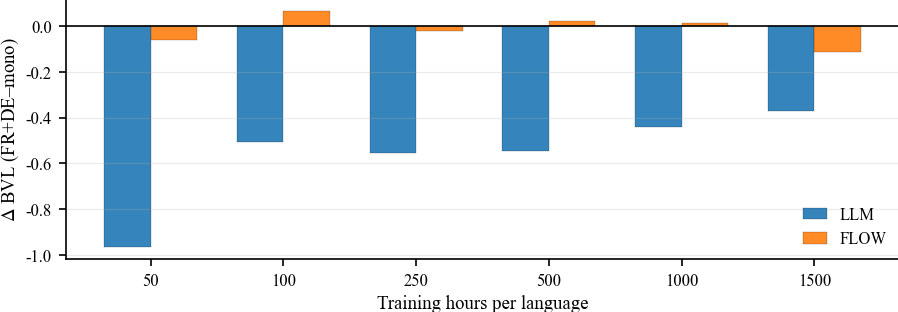

In [14]:

mono = (
    df[df["lang"].isin(["FR","DE"])]
      .groupby(["model","hours_per_lang"])["val_loss_best_filled"]
      .mean()
      .reset_index(name="MonoLoss")
)
mix = df[df["lang"]=="MIX"][["model","hours_per_lang","val_loss_best_filled"]].rename(
    columns={"val_loss_best_filled":"MixLoss"}
)
cmp = mono.merge(mix, on=["model","hours_per_lang"], how="inner")
cmp["DeltaLoss"] = cmp["MixLoss"] - cmp["MonoLoss"]  # < 0 → MIX better

hours = sorted(cmp["hours_per_lang"].unique())
label_ticks = hours
models = ["LLM", "FLOW"]
width = 0.35
lw = 0.1

fig, ax = plt.subplots(figsize=(DOUBLE_COL_W, 2.25))

xpos = np.arange(len(hours))
for i, model in enumerate(models):
    sub = cmp[cmp["model"] == model].set_index("hours_per_lang").reindex(hours)
    if sub["DeltaLoss"].isna().all():
        continue
    vals = sub["DeltaLoss"].values
    ax.bar(
        xpos + (i - 0.5)*width,
        vals,
        width=width,
        label=model,
        edgecolor="black",
        linewidth=lw,
        alpha=0.9,
    )

ax.axhline(0, color="black", linewidth=0.8)
ax.set_xticks([hours.index(t) if t in hours else None for t in label_ticks])  # positions for shown labels
ax.set_xticklabels([str(int(t)) for t in label_ticks])

_finalize_axes(
    ax,
    title=None,
    xlabel="Training hours per language",
    ylabel=r"$\Delta$ BVL (FR+DE–mono)",
    legend=False
)

# legend top-right inside
ax.legend(loc="lower right", frameon=False, handlelength=1.4, borderpad=0.2)

Path("plots").mkdir(parents=True, exist_ok=True)
_save_and_show(fig, "plots/mix_vs_mono_delta_val_loss.pdf", show=True)


Accuracy vs Hours

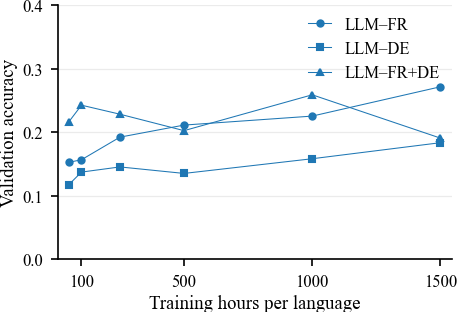

In [15]:
df_acc = df[(df["model"] == "LLM") & (~df["val_acc_final"].isna())].copy()
df_acc = df_acc.sort_values(["lang","hours_per_lang"])

markers = {"FR": "o", "DE": "s", "MIX": "^"}
color = "C0"
lw = 0.5

all_hours = sorted(df_acc["hours_per_lang"].unique())
label_ticks = [h for h in [100, 500, 1000, 1500] if h in all_hours]

fig, ax = plt.subplots(figsize=(SINGLE_COL_W, 2.2))

for lang in ["FR", "DE", "MIX"]:
    sub = df_acc[df_acc["lang"] == lang]
    if sub.empty:
        continue
    x = sub["hours_per_lang"].values
    y = sub["val_acc_final"].values
    order = np.argsort(x)
    ax.plot(
        x[order], y[order],
        marker=markers[lang], linestyle="-",
        linewidth=lw, markersize=3,
        color=color, label=f"LLM–{'FR+DE' if lang == 'MIX' else lang}",
    )

# tidy y-range if accuracy is 0–1
if df_acc["val_acc_final"].max() <= 1.05 and df_acc["val_acc_final"].min() >= -0.05:
    ax.set_ylim(0, 0.4)

ax.set_xticks(label_ticks)
ax.set_xticklabels([str(int(t)) for t in label_ticks])
ax.margins(x=0.03)

_finalize_axes(
    ax,
    title=None,
    xlabel="Training hours per language",
    ylabel="Validation accuracy",
    legend=False
)
ax.legend(loc="upper right", frameon=False, handlelength=1.4, borderpad=0.2)

Path("plots").mkdir(parents=True, exist_ok=True)
_save_and_show(fig, "plots/val_accuracy_vs_hours_llm.pdf", show=True)


### Backbone Analysis: Alternative LLM Architectures (3000h)

Comparison of different backbone architectures for semantic token prediction:
- **CosyVoice2 (original)**: `llm_3000h-blanken-lora_false` 
- **Mistral-7B**: `llm_3000h-hf-mistralai-Mistral-7B-v0.3-lora_true`
- **Qwen3-0.6B**: `llm_3000h-hf-Qwen-Qwen3-0.6B-lora_true` 
- **EuroLLM-1.7B**: `llm_3000h-hf-utter-project-EuroLLM-1.7B-Instruct-lora_true`

In [9]:
# Define backbone run patterns for 3000h experiments
# BACKBONE_PATTERNS = {
#     "CosyVoice2 (original)": "llm_3000h-blanken-lora_false",
#     "Mistral-7B": "llm_3000h-hf-mistralai-Mistral-7B-v0.3-lora_true_mix",
#     "Qwen3-0.6B": "llm_3000h-hf-Qwen-Qwen3-0.6B-lora_true_mix", 
#     "EuroLLM-1.7B": "llm_3000h-hf-utter-project-EuroLLM-1.7B-Instruct-lora_true_mix"
# }


BACKBONE_ID = {
    "CosyVoice2 (original)": "1rggyz2g",
    "Mistral-7B": "w4cgp3zp",  # run ID for Mistral-7B
    "Qwen3-0.6B": "2e04avhp",
    "EuroLLM-1.7B": "ffbq6iyr"  # run ID for EuroLLM-1.7B
}

# Fetch all runs and filter for backbone experiments
backbone_runs = []
for run in api.runs(f"{ENTITY}/{PROJECT}"):
    run_name = run.name or ""
    run_id = run.id
    for backbone_label, id in BACKBONE_ID.items():
        if run_id == id:
            backbone_runs.append({
                "backbone": backbone_label,
                "run": run,
                "run_name": run_name,
                "run_id": run.id
            })
            break

print(f"Found {len(backbone_runs)} backbone comparison runs:")
for br in backbone_runs:
    print(f"- {br['backbone']}: {br['run_name']}")

Found 4 backbone comparison runs:
- EuroLLM-1.7B: llm_3000h-hf-utter-project-EuroLLM-1.7B-Instruct-lora_true_mix
- CosyVoice2 (original): llm_3000h-blanken-lora_false
- Qwen3-0.6B: llm_3000h-hf-Qwen-Qwen3-0.6B-lora_true_mix
- Mistral-7B: llm_3000h-hf-mistralai-Mistral-7B-v0.3-lora_true_mix


In [10]:
# DEBUG: Let's inspect what data we can actually get from W&B runs
print("=== DEBUGGING W&B DATA STRUCTURE ===")

if backbone_runs:
    # Take the first available run to debug
    debug_run = backbone_runs[0]["run"]
    print(f"Debugging run: {backbone_runs[0]['run_name']}")
    
    try:
        history = debug_run.history(samples=1000)  # smaller sample for debug
        print(f"\nHistory shape: {history.shape}")
        print(f"Available columns: {list(history.columns)}")
        
        # Look for epoch-related columns
        epoch_cols = [col for col in history.columns if 'epoch' in col.lower()]
        print(f"\nEpoch-related columns: {epoch_cols}")
        
        # Look for loss columns
        loss_cols = [col for col in history.columns if 'loss' in col.lower()]
        print(f"Loss-related columns: {loss_cols}")
        
        # Show actual data structure with the correct column names
        print(f"\nFirst 5 rows of key columns:")
        key_cols = [col for col in ['train/epoch', 'train/loss', 'cv/epoch', 'cv/loss'] if col in history.columns]
        if key_cols:
            display(history[key_cols].head(10))
        
        # Check actual epoch ranges
        if 'train/epoch' in history.columns:
            train_epochs = history['train/epoch'].dropna()
            print(f"\nTrain epoch range: {train_epochs.min():.2f} to {train_epochs.max():.2f}")
            print(f"Train unique epochs: {sorted(train_epochs.unique())}")
            
        if 'cv/epoch' in history.columns:
            cv_epochs = history['cv/epoch'].dropna()
            print(f"\nCV epoch range: {cv_epochs.min():.2f} to {cv_epochs.max():.2f}")
            print(f"CV unique epochs: {sorted(cv_epochs.unique())}")
        
    except Exception as e:
        print(f"Error accessing run history: {e}")
else:
    print("No backbone runs found for debugging")

=== DEBUGGING W&B DATA STRUCTURE ===
Debugging run: llm_3000h-hf-utter-project-EuroLLM-1.7B-Instruct-lora_true_mix

History shape: (1000, 15)
Available columns: ['train/acc', 'cv/grad_norm', 'train/loss', '_timestamp', 'cv/lr', 'cv/step', 'cv/loss', '_step', 'train/lr', 'train/step', 'train/epoch', 'train/grad_norm', 'cv/acc', '_runtime', 'cv/epoch']

Epoch-related columns: ['train/epoch', 'cv/epoch']
Loss-related columns: ['train/loss', 'cv/loss']

First 5 rows of key columns:


,train/epoch,train/loss,cv/epoch,cv/loss
0,0,1.739763,None,None
1,0,1.694745,None,None
2,0,1.866401,None,None
3,0,1.870561,None,None
4,0,1.818126,None,None
5,0,1.764093,None,None
6,0,1.665019,None,None
7,0,1.705828,None,None
8,0,1.812718,None,None
9,0,1.547400,None,None



Train epoch range: 0.00 to 10.00
Train unique epochs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

CV epoch range: nan to nan
CV unique epochs: []


  0%|          | 0/4 [00:00<?, ?it/s]

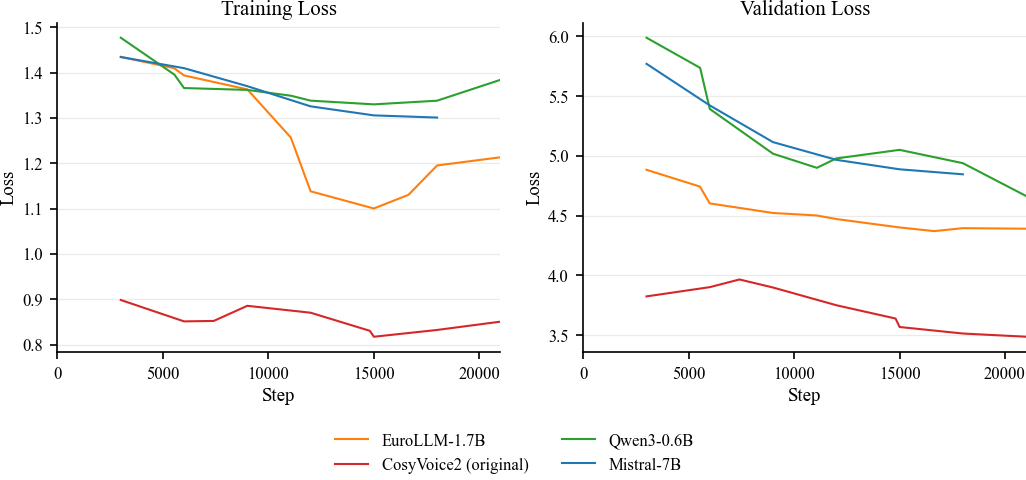

In [11]:
from scipy.ndimage import gaussian_filter1d

def extract_step_curves(run, step_max=21000, sigma=None, target_points=None):
    """
    Return (train_steps, train_loss, cv_steps, cv_loss) using batch-level steps.
    - Handles resumes by keeping the *last* value for each step.
    - If the trainer resets step on resume, we make a contiguous step counter.
    - sigma: float for optional Gaussian smoothing (standard deviation); None to disable.
    - target_points: int to decimate plotted points; None to keep all.
    """
    rows = list(run.scan_history(keys=[
        "train/step","train/loss","cv/step","cv/loss","_step"
    ]))
    if not rows:
        return np.array([]), np.array([]), np.array([]), np.array([])

    df = pd.DataFrame(rows)
    for c in ["train/step","train/loss","cv/step","cv/loss","_step"]:
        if c in df:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    df = df.dropna(subset=["_step"]).sort_values("_step")

    def contiguous_and_last(df, step_col, y_col):
        if step_col not in df or y_col not in df:
            return np.array([]), np.array([])

        t = df[[step_col, y_col, "_step"]].dropna().sort_values("_step")
        if t.empty:
            return np.array([]), np.array([])

        # Build a contiguous step in case step resets after resume
        s = t[step_col].to_numpy()
        contig = np.empty_like(s, dtype=float)
        offset = 0.0
        prev = s[0]
        for i, v in enumerate(s):
            if v < prev:          # detected a reset
                offset += prev    # shift subsequent steps forward
            contig[i] = v + offset
            prev = v
        t["contig_step"] = contig

        # Keep the *last* value per (contiguous) step
        t = t.groupby("contig_step", as_index=False).agg({y_col: "last"})

        # Limit to desired max step
        if step_max is not None:
            t = t.loc[t["contig_step"] <= step_max]

        x = t["contig_step"].to_numpy()
        y = t[y_col].to_numpy()

        # Optional Gaussian smoothing
        if sigma is not None and sigma > 0 and y.size > 1:
            y = gaussian_filter1d(y, sigma=sigma)

        # Optional decimation to keep plots light
        if target_points and y.size > target_points:
            stride = int(np.ceil(y.size / target_points))
            x, y = x[::stride], y[::stride]

        return x, y

    tr_x, tr_y = contiguous_and_last(df, "train/step", "train/loss")
    cv_x, cv_y = contiguous_and_last(df, "cv/step",    "cv/loss")
    return tr_x, tr_y, cv_x, cv_y

def plot_backbone_by_step(backbone_runs, outpdf="plots/backbone_by_step.pdf",
                          step_max=21000, sigma=1.0, target_points=4000,
                          width=DOUBLE_COL_W, height=3.0):
    colors = {
        "CosyVoice2 (original)": "C3",
        "Mistral-7B": "C0",
        "Qwen3-0.6B": "C2",
        "EuroLLM-1.7B": "C1"
    }
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(width, height))

    for br in tqdm(backbone_runs):
        tr_x, tr_y, cv_x, cv_y = extract_step_curves(
            br["run"], step_max=step_max, sigma=sigma, target_points=target_points
        )
        col = colors.get(br["backbone"], None)
        if tr_x.size:
            ax1.plot(tr_x, tr_y, label=br["backbone"], linewidth=1.0, color=col)
        if cv_x.size:
            ax2.plot(cv_x, cv_y, label=br["backbone"], linewidth=1.0, color=col)

    _finalize_axes(ax1, title="Training Loss",   xlabel="Step", ylabel="Loss", legend=False)
    _finalize_axes(ax2, title="Validation Loss", xlabel="Step", ylabel="Loss", legend=False)

    # Ensure x-axis starts at 0
    ax1.set_xlim(0, step_max)
    ax2.set_xlim(0, step_max)

    handles, labels = ax1.get_legend_handles_labels()
    if not handles:
        handles, labels = ax2.get_legend_handles_labels()
    if handles:
        fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, 0.02),
                   ncol=2, frameon=False, fontsize=8)
        plt.subplots_adjust(bottom=0.15)

    plt.tight_layout()
    _save_and_show(fig, outpdf, show=True)

plot_backbone_by_step(backbone_runs, step_max=21000, sigma=1.0, outpdf="plots/backbone_by_step.pdf")